Check out Kaggle at https://www.kaggle.com/c/lish-moa/overview, a challenge by the Laboratory of Innovation Science at Harvard. The objective is to use underlying drug characteristics to classify them into groups related to biological activity. 

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import collections
import gc
import pickle
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Lambda, Flatten, Conv2DTranspose
from tensorflow.keras.layers import Dropout, GaussianNoise, Input, UpSampling2D, Concatenate
from tensorflow.keras.models import Model, Sequential, load_model
import sklearn.model_selection
from copy import deepcopy
import sklearn.metrics
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

<h2> STEP 1 - Data Preprocessing

In [2]:
X = pd.read_csv("./data/train_features.csv")
Y = pd.read_csv("./data/train_targets_scored.csv")
supp = pd.read_csv("./data/train_targets_nonscored.csv")
X.shape, Y.shape, supp.shape

((23814, 876), (23814, 207), (23814, 403))

In [3]:
def get_bad_cols(thresh=0.75):
    crr = X[X.columns.values[4:]].corr()
    tbl = crr.stack().reset_index()
    tbl.drop(tbl.loc[tbl.level_0==tbl.level_1].index, inplace=True)
    badcols = set()
    badvals = tbl.loc[tbl[0].apply(np.abs)>=thresh]
    while len(badvals)>0:
        vals = badvals["level_0"].append(badvals["level_1"]).value_counts()
        badcols.add(vals.index.values[0])
        badvals = badvals.loc[(badvals["level_0"]!=vals.index.values[0])&
                              (badvals["level_1"]!=vals.index.values[0])]
    newtbl = tbl.loc[(tbl.level_0.isin(list(badcols))==False)&(tbl.level_1.isin(list(badcols))==False)]
    return badcols, tbl, newtbl
badcols, tbl, newtbl = get_bad_cols(0.75)
X.drop(columns=list(badcols), inplace=True)

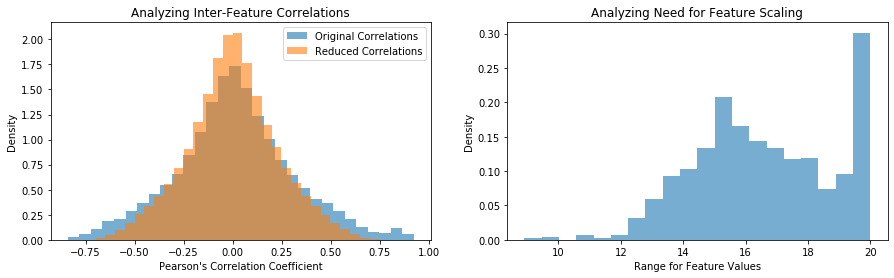

In [4]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.hist(tbl[0], bins=30, alpha=0.6, label="Original Correlations", density=True)
plt.hist(newtbl[0], bins=30, alpha=0.6, label="Reduced Correlations", density=True)
plt.legend(loc="best")
plt.xlabel("Pearson's Correlation Coefficient")
plt.ylabel("Density")
plt.title("Analyzing Inter-Feature Correlations")
plt.subplot(1,2,2)
X[X.columns.values[4:]].apply(lambda s: s.max()-s.min()).plot(kind="hist", bins=20, alpha=0.6, density=True)
plt.xlabel("Range for Feature Values")
plt.ylabel("Density")
plt.title("Analyzing Need for Feature Scaling")
plt.show()

In [5]:
newX = np.zeros((X.shape[0], X.shape[1]+3))
newX[X["cp_type"]=="trt_cp",0] = 1
newX[X["cp_type"]=="ctl_vehicle",1] = 1
newX[X["cp_time"]==48,2] = 1
newX[X["cp_time"]==72,3] = 1
newX[X["cp_time"]==24,4] = 1
newX[X["cp_dose"]=="D1",5] = 1
newX[X["cp_dose"]=="D2",6] = 1
newX[:,7:] = X[X.columns.values[4:]].values
Y.drop(columns=["sig_id"], inplace=True)

<h2> STEP 2 - Stacked Classifiers

In [7]:
def get_rf(dataX, dataY):
    params = {'max_depth':[5,7,9], 'min_samples_split':[2,3], 'criterion':['gini','entropy'], 
              'max_samples':[None,0.85,0.7]}
    mdl = RandomForestClassifier(class_weight="balanced", random_state=1, n_estimators=40)
    rfmdl = RandomizedSearchCV(mdl, params, scoring=["neg_log_loss","neg_brier_score"], refit="neg_log_loss", 
                               cv=4, n_iter=8, return_train_score=True, verbose=999999, random_state=1)
    rfmdl.fit(dataX, dataY)
    return rfmdl

In [42]:
nomdl = Y.apply(np.sum)
ymdl = nomdl[nomdl>10].index.values
nomdl = nomdl[nomdl<=10].index.values
for char in ymdl:
    mdl = get_rf(newX[:15000], Y[char].values[:15000])
    pickle.dump(mdl, open("./RF_"+char+".pkl","wb"))